# Basic Analysis of the weights

### Network Architecture

In [35]:
from keras.models import load_model,Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import keras.backend as K
from Environments import CreateEnvironment,CreateFinalTestCases
#activations = np.load('Hidden_Activation.npy')
inputs = np.load('Input_Final_Cases.npy')
activations = np.load('Hidden_Activation_Final_Cases.npy')
outputs = np.load('Output_Final_Cases.npy')
##### Function to make drawing easier (ignore)#####
def plotscatter(rstart,rend,color,neuron):
    return plt.scatter(np.array(range(rstart,rend)),model.get_weights()[0][:,neuron][rstart:rend],color=color)
def plotneuron(neuron):
    plt.figure(figsize=(13,5))
    #plt.scatter(np.array(range(633)),model.get_weights()[0][:,61],s=100,c='black')#,c=model.get_weights()[0][:,61],s=100)
    observed = plotscatter(0,121,'#fb00ff',neuron)
    mypos = plotscatter(121,242,'#1f77b4',neuron)
    myori = plotscatter(242,246,'#5ff441',neuron)
    obstacles = plotscatter(246,367,'#f4d341',neuron)
    food = plotscatter(367,488,'#000000',neuron)
    dompos= plotscatter(488,609,'#41f4eb',neuron)
    lastactions=plotscatter(613,633,'#415ef4',neuron)
    domori=plotscatter(609,613,'#f44141',neuron)
    plt.legend(handles=[observed, mypos,myori,obstacles,food,dompos,domori,lastactions],
               labels=['Observed','sub position','sub orientation','obstacles','food','dom position','dom orientation','last actions'],loc=2)
    plt.xlabel('Input',fontsize=15,fontweight='bold')
    plt.ylabel('Weight value',fontsize=15,fontweight='bold')
    plt.title('Weights from input to neuron {}'.format(neuron),fontsize=15,fontweight='bold')

def TSNE_THIS(X,title,names=None,seed=None,preplexity=5.0,redgroup=[],bgroup=[],n_itre=5000,
              metric='euclidean',method='barnes_hut',trigroup=[],circlgroup=[]):
    X_embedded = TSNE(n_components=2,n_iter=n_itre,perplexity=preplexity,random_state=seed,metric=metric,method=method).fit_transform(X.T)
    plt.figure(figsize=(13,5))
    
    if names is None:
        plt.scatter(X_embedded[:,0],X_embedded[:,1])
        for i in range(1,X_embedded.shape[0]+1):
            plt.annotate(xy=(X_embedded[i-1,0],X_embedded[i-1,1]),s=str(i))
    else:
        #Shape & Color
        for i in range(1,X_embedded.shape[0]+1):
            color='C0'
            shape=None
            if names[i-1] in redgroup:
                color = 'r'
            elif names[i-1] in bgroup:
                color = 'b'
            if names[i-1] in circlgroup:
                #shape ='o'
                shape=None
            elif names[i-1] in trigroup:
                shape='^'
            plt.scatter(X_embedded[i-1,0],X_embedded[i-1,1],c=color,marker=shape)

        #Annotation
        for i in range(1,X_embedded.shape[0]+1):
            plt.annotate(xy=(X_embedded[i-1,0],X_embedded[i-1,1]),s=str(int(names[i-1])))
            
    #plt.title(title+',perplexity:{}'.format(preplexity),fontsize=15,fontweight='bold')
    return plt

def Squar(rstart,rend,neuron,ax,title,fig,Data=None):
    if Data is not None:
        tmp=np.reshape(np.array(Data[rstart:rend]),(11,11))
    else:
        tmp=np.reshape(np.array(model.get_weights()[0][:,neuron][rstart:rend]),(11,11))
    cax=ax.imshow(tmp,cmap='coolwarm')
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(cax,ax=ax)
    return cax

def plotsquares(neuron,Data=None):
    fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(ncols=3,nrows=2,figsize=(16,10))
    xs=1
    ys=5
    observed = Squar(0,121,neuron,ax0,'Observed',fig,Data)
    mypos = Squar(121,242,neuron,ax1,'Subordinate Position',fig,Data)
    obstacles = Squar(246,367,neuron,ax2,'Obstacles',fig,Data)
    food = Squar(367,488,neuron,ax3,'Food',fig,Data)
    dompos= Squar(488,609,neuron,ax4,'Dominant Position',fig,Data)
    restinfo = np.zeros((6,5))
    if Data is not None:
        restinfo[0,:-1] = np.array(Data[242:246]) #myori
        restinfo[1,:-1]= np.array(Data[609:613]) #DOMori
        restinfo[2:]=np.reshape(np.array(model.get_weights()[0][:,neuron][613:633]),(4,5)) #Last actions
    else:
        restinfo[0,:-1] = np.array(model.get_weights()[0][:,neuron][242:246]) #myori
        restinfo[1,:-1]= np.array(model.get_weights()[0][:,neuron][609:613]) #DOMori
        restinfo[2:]=np.reshape(np.array(model.get_weights()[0][:,neuron][613:633]),(4,5)) #Last actions
    cax =ax5.imshow(restinfo,cmap='coolwarm')
    ax5.set_yticklabels(['','Sub orientation','Dom orientation','last action 4','last action 3','last action 2','last action 1'],rotation=45)
    ax5.set_xticklabels(['','N','S','W','E','Stay'])
    fig.colorbar(cax,ax=ax5)
    plt.title('Orientations and previous actions'.format(neuron))
    
def PrepareTestCases(array):
    array = np.array(array,dtype=np.float64)
    return np.concatenate([array,array+100,array+200,array+300,array+400])

def Gradient_Based (x,label):
    pred = model.predict_on_batch(x)
    print(pred)
    grads = K.gradients(model.output[0, label], model.input)
    grads_saliency = K.function([model.input, K.learning_phase()], grads)
    x_grads = grads_saliency([x, 0])[0]
    return x_grads
###################################################
%matplotlib inline
model = load_model('output/599/MOD/model.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 633)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           63400       input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 6)             606         dense_1[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 5)             0           dense_2[0][0]                    
Total params: 64,006
Trainable params: 64,006
Non-trainable params: 0
_____________________

In [36]:
preferences = CreateFinalTestCases()

[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]


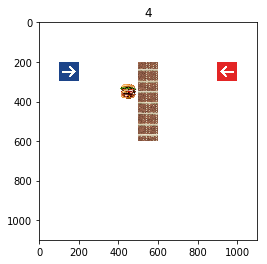

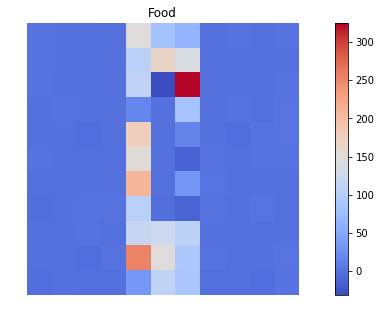

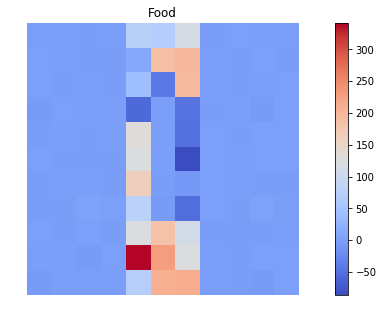

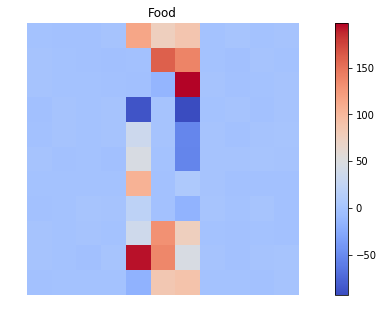

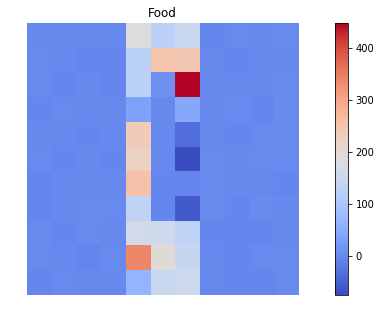

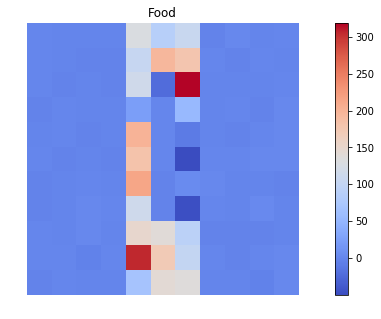

In [42]:
game= CreateEnvironment(preferences[1],4)
game.Step()
plt.imshow(game.BuildImage())
plt.title(i)
x = game.agents[1001].Flateoutput()
x = np.array([x])
for i in range(5):
    x_r_grads = Gradient_Based(x,i)
    fig,(())
    Squar(367,488,neuron,ax0,'Food',fig,x_r_grads)
    plotsquaresFood(61,Data=x_r_grads)

[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]


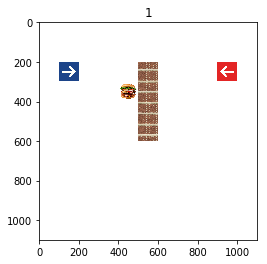

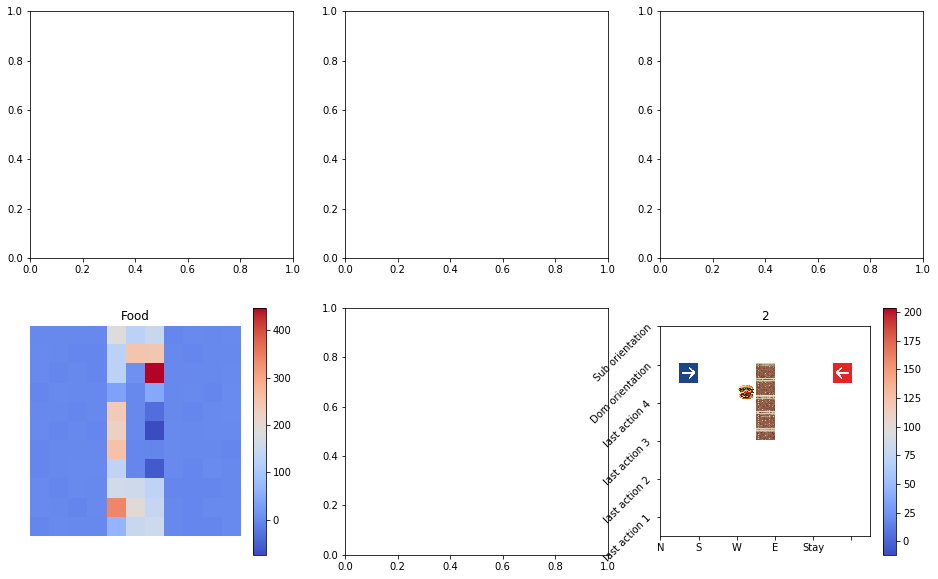

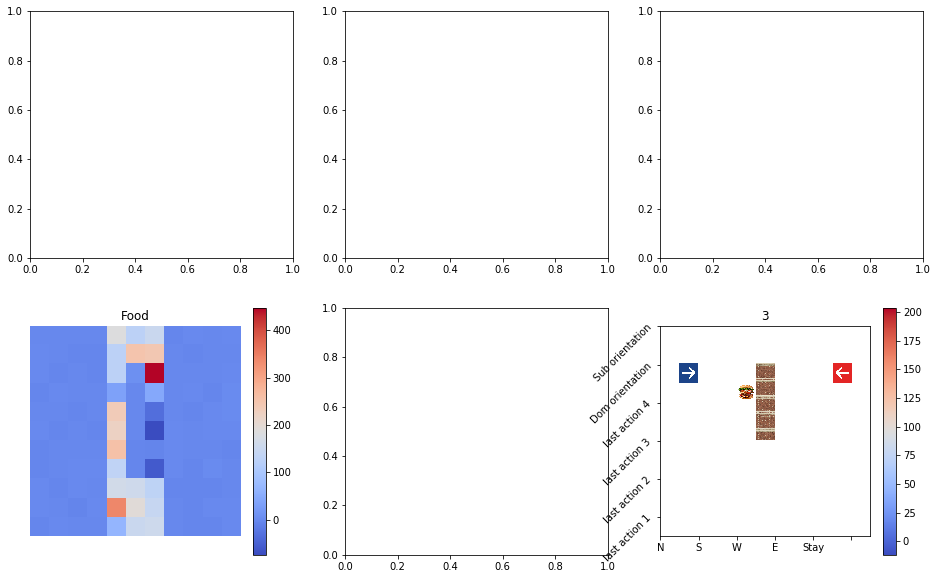

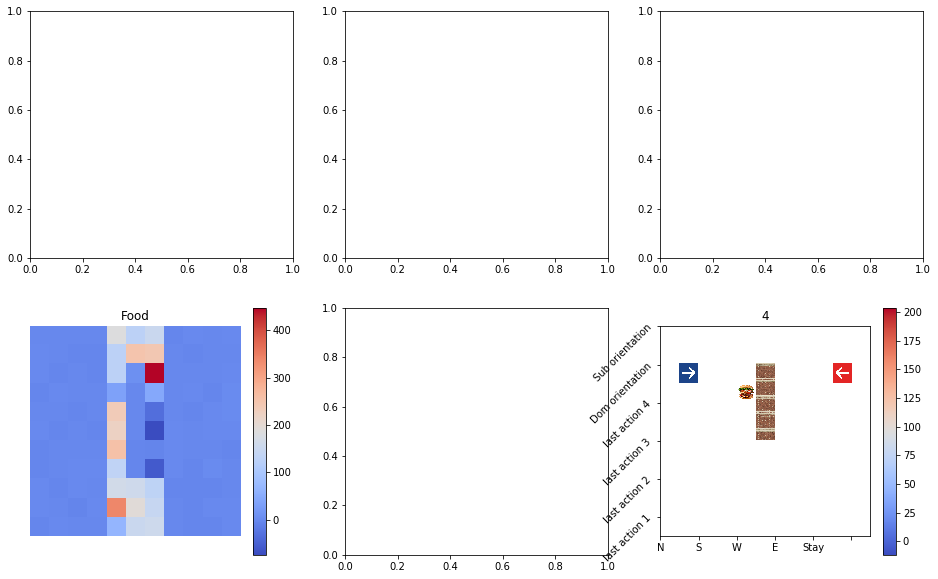

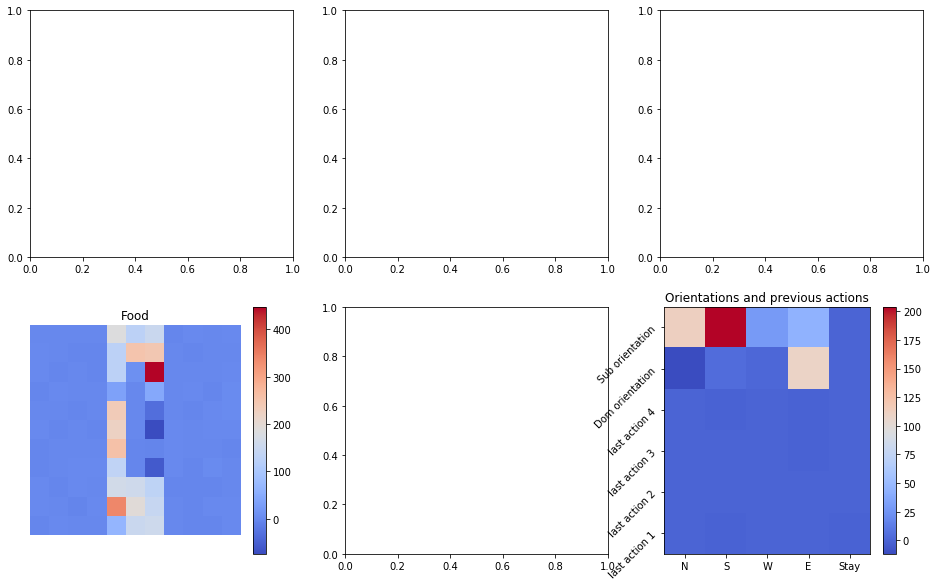

In [31]:
for i in range(1,5):
    game= CreateEnvironment(preferences[1],4)
    game.Step()

    plt.imshow(game.BuildImage())
    plt.title(i)
    x = game.agents[1001].Flateoutput()
    x = np.array([x])
    x_r_grads = Gradient_Based(x,3)
    #x_l_grads = Gradient_Based(x,1)
    plotsquares(61,Data=x_r_grads)

[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 541.79571533  432.25869751  382.53674316  594.79309082  569.43109131]]
[[ 417.16986084  669.14538574  279.97814941  854.87615967  757.10931396]]
[[ 477.36309814  529.43640137  284.40032959  758.59069824  661.6897583 ]]
[[ 543.26605225  215.32893372  327.81408691  418.86199951  414.96942139]]
[[ 416.00219727  567.70379639  351.82556152  695.74810791  619.7230835 ]]
[[ 470.95367432  398.49407959  373.19335938  490.98205566  478.65588379]]
[[ 413.53494263  837.97692871  311.89407349  944.34472656  824.30358887]]
[[ 334.00817871  650.14819336  293.80041504  750.61987305  645.67755127]]
[[ 666.32647705  430.0043335   280.3583374   855.08172607  737.51983643]]


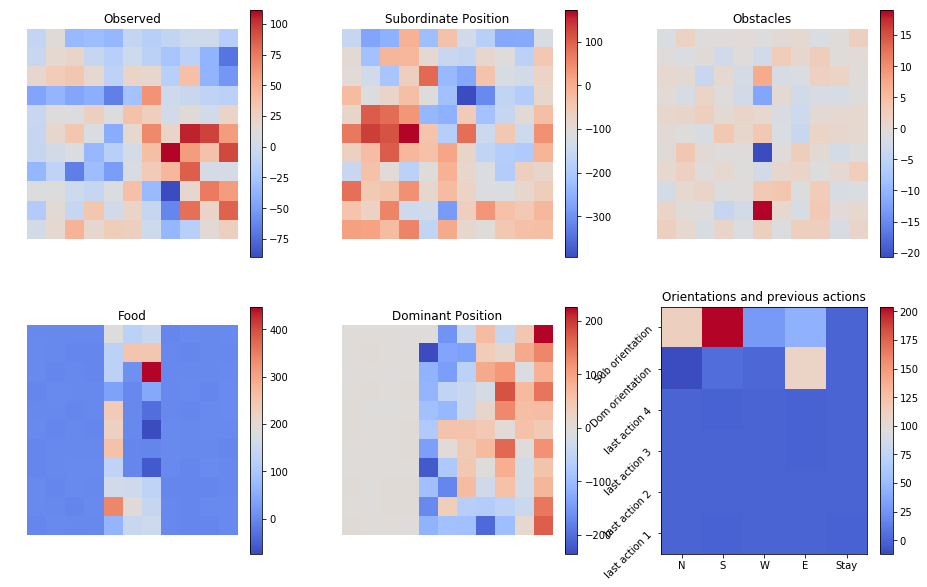

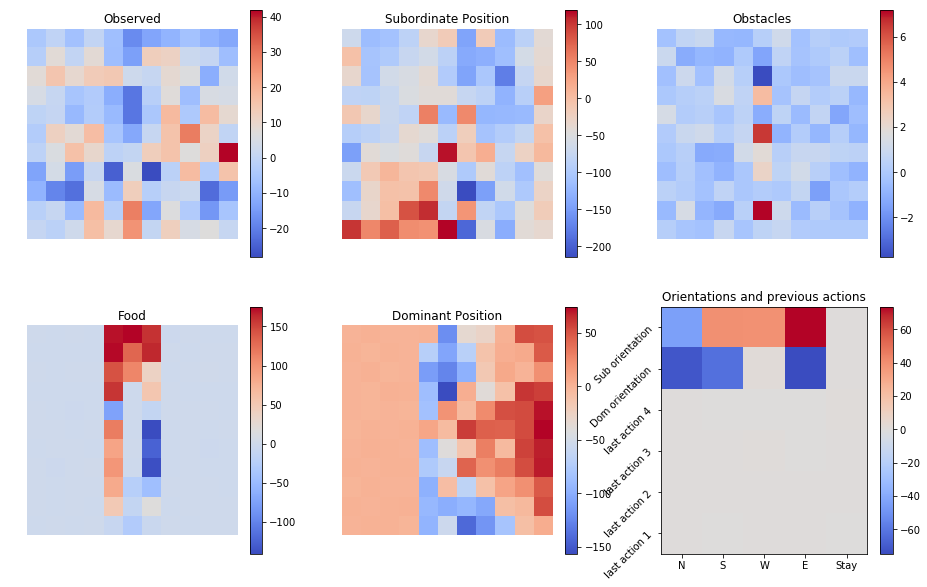

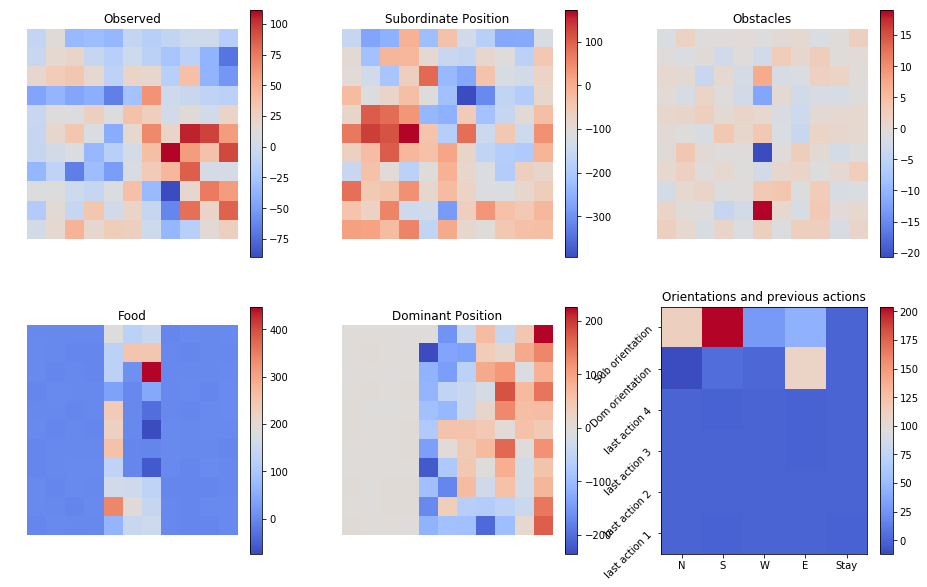

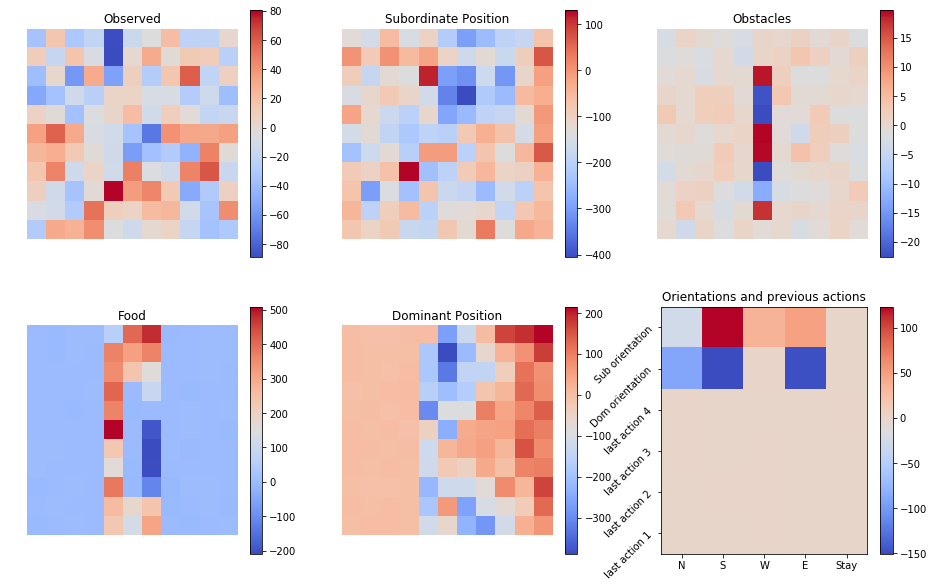

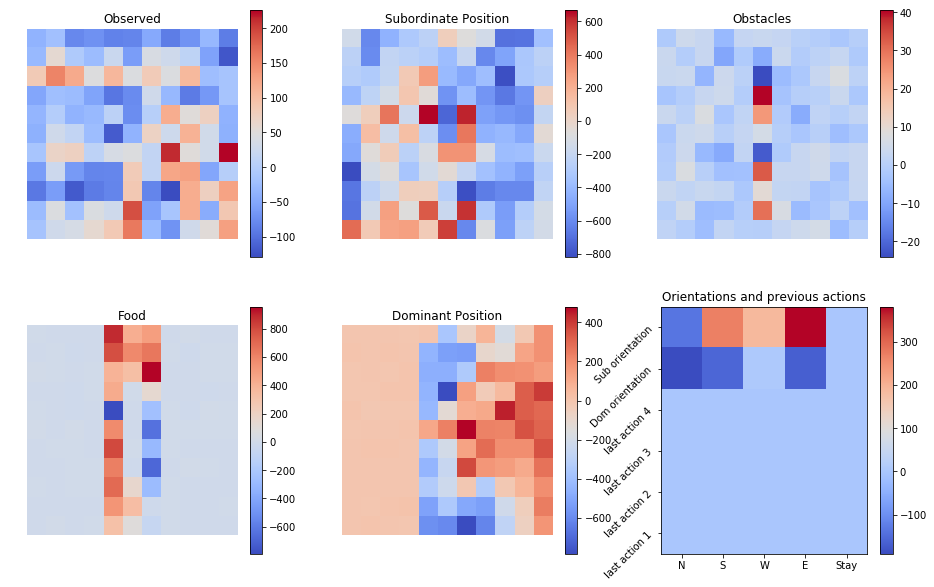

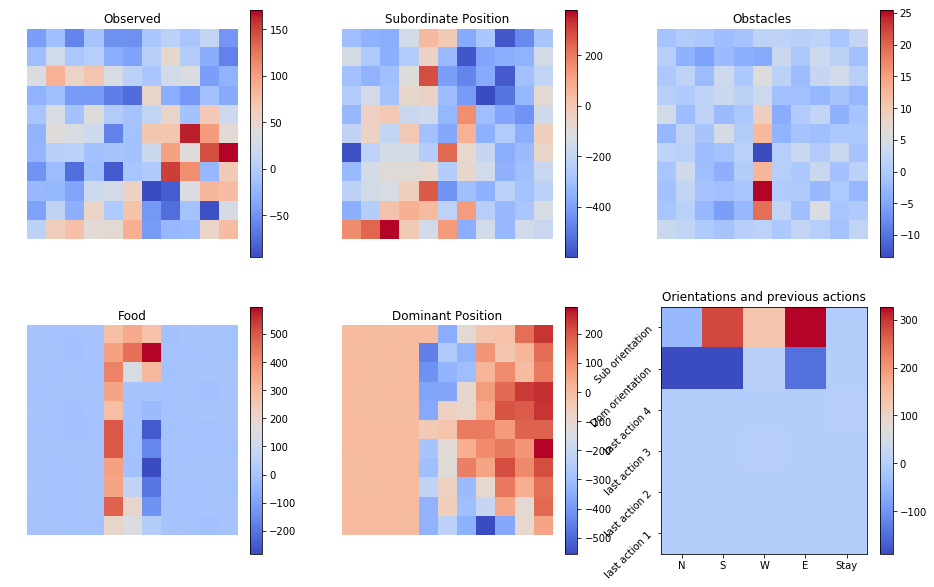

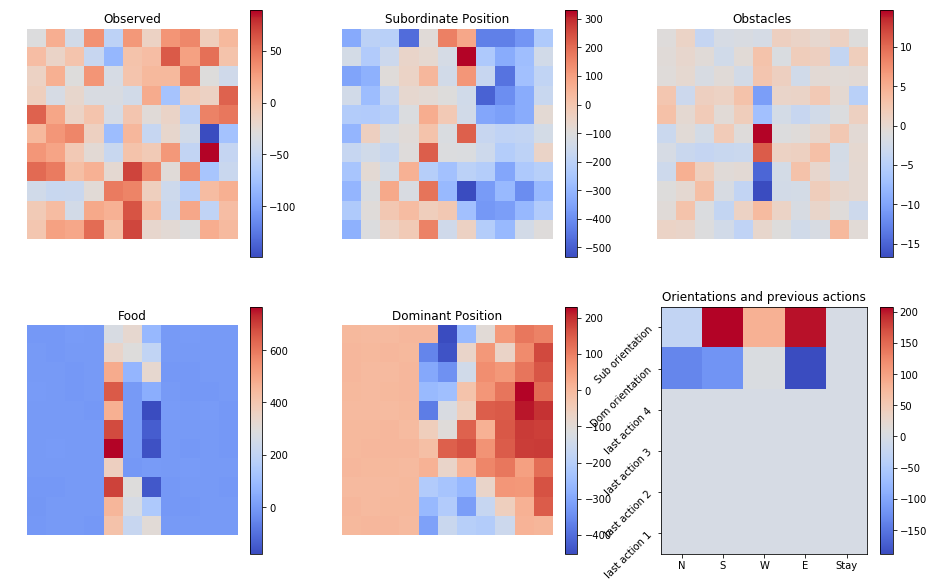

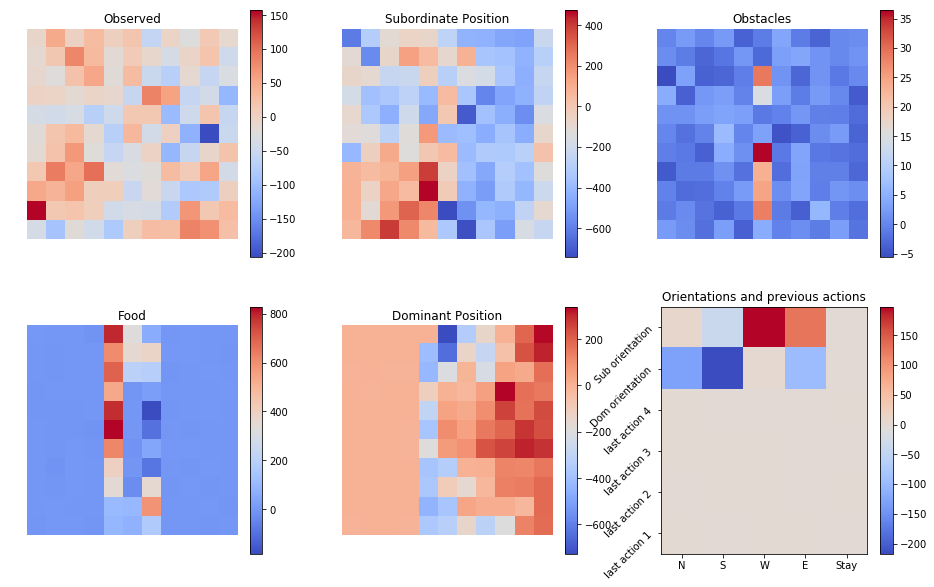

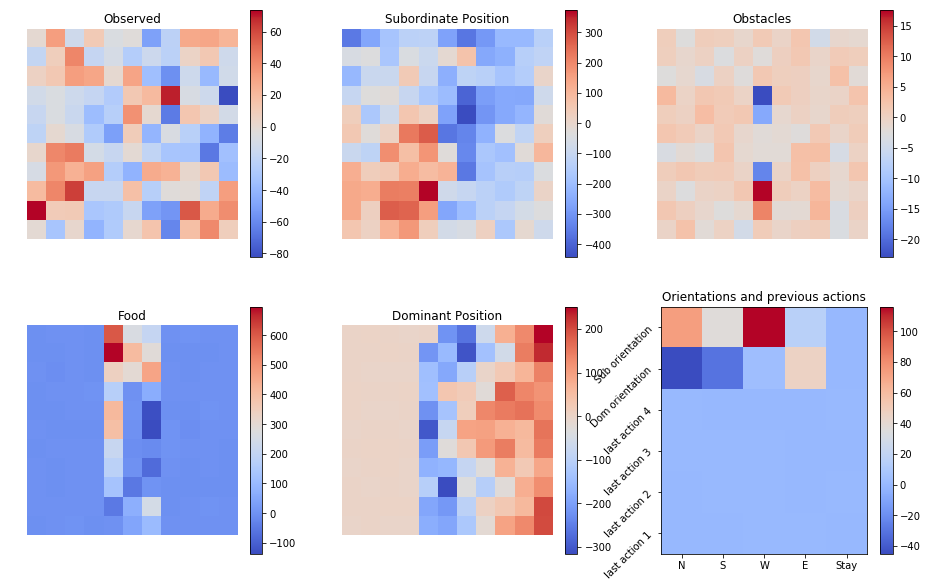

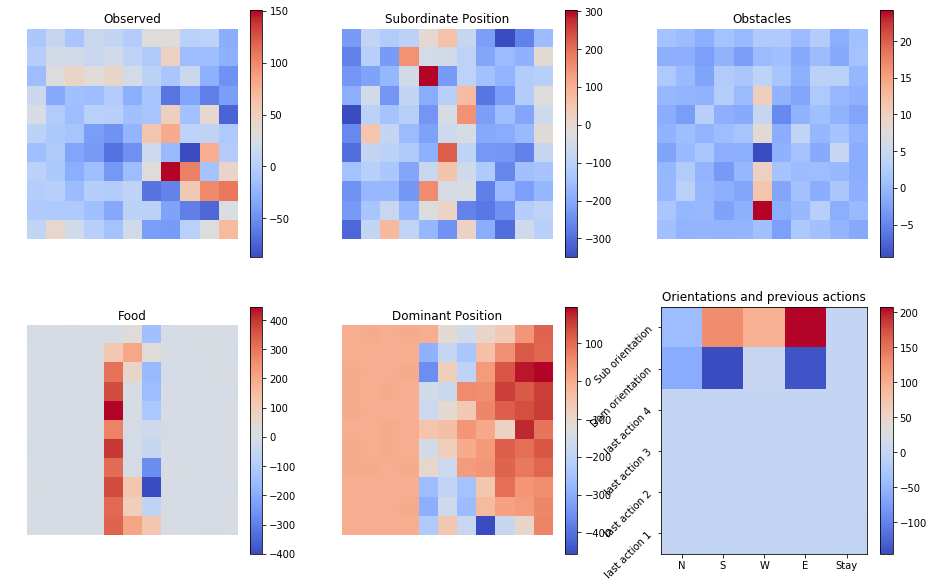

In [13]:
for i in range(1,11):
    game= CreateEnvironment(preferences[i],4)
    game.Step()
    #plt.Figure()
    #plt.imshow(game.BuildImage())
    #plt.title(i)
    x = game.agents[1001].Flateoutput()
    x = np.array([x])
    x_grads = Gradient_Based(x,4)
    plotsquares(61,Data=x_grads)

In [185]:
model.weights

[dense_1_W, dense_1_b, dense_2_W, dense_2_b]

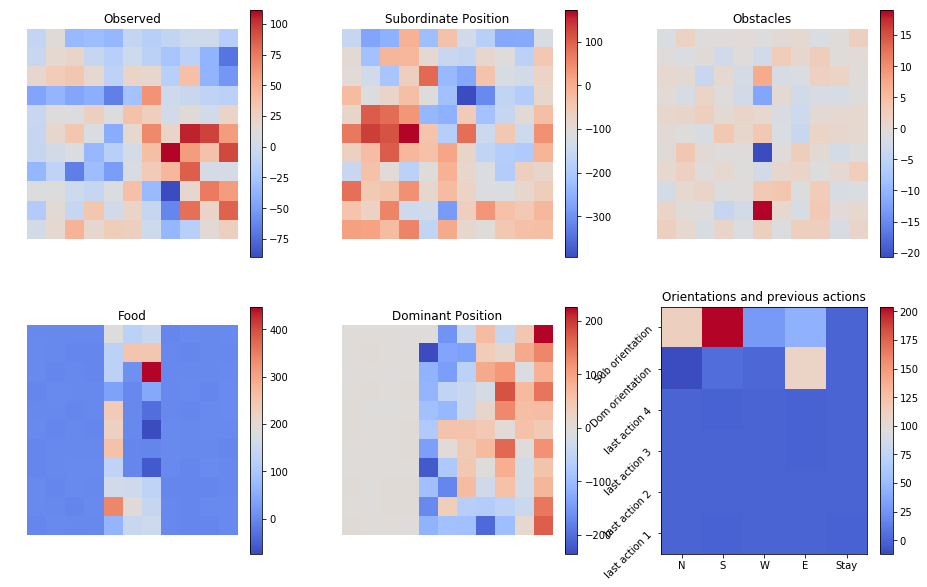

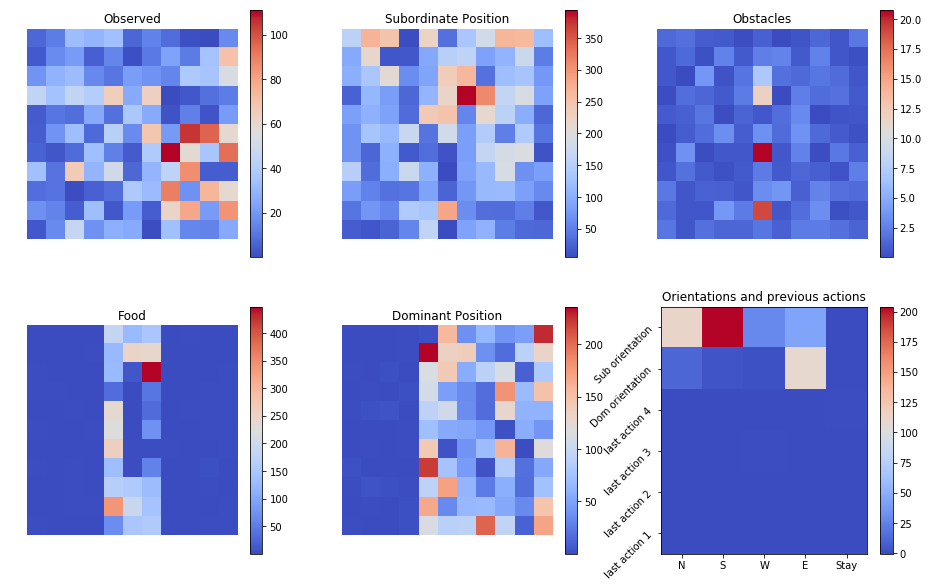

### Weights Hidden&rarr;State Value

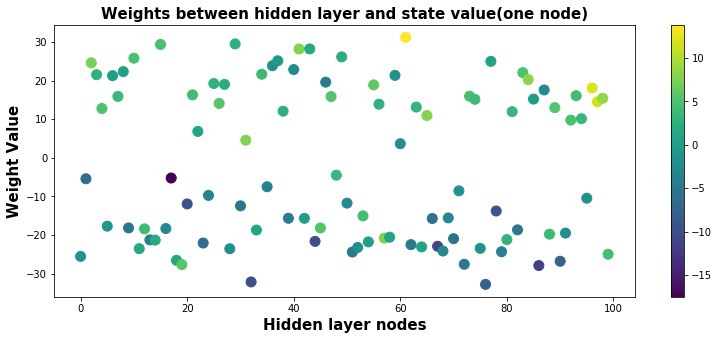

In [173]:
plt.figure(figsize=(13,5))
plt.scatter(np.array(range(100)),model.get_weights()[2][:,0],c=model.get_weights()[2][:,5],s=100)
plt.xlabel('Hidden layer nodes',fontsize=15,fontweight='bold')
plt.ylabel('Weight Value',fontsize=15,fontweight='bold')
plt.title('Weights between hidden layer and state value(one node)',fontsize=15,fontweight='bold')
plt.colorbar()
plt.show()

### Hidden layer neurons with Maximum,Minimum weights with the "state value node"

In [174]:
print(' Max weight neuron:',np.argmax(model.get_weights()[2][:,0]),'\n','Min weight neuron:',np.argmin(model.get_weights()[2][:,0]))

 Max weight neuron: 61 
 Min weight neuron: 76


### Weights Input&rarr;neuron 61 neuron with most negative weight value in next layer

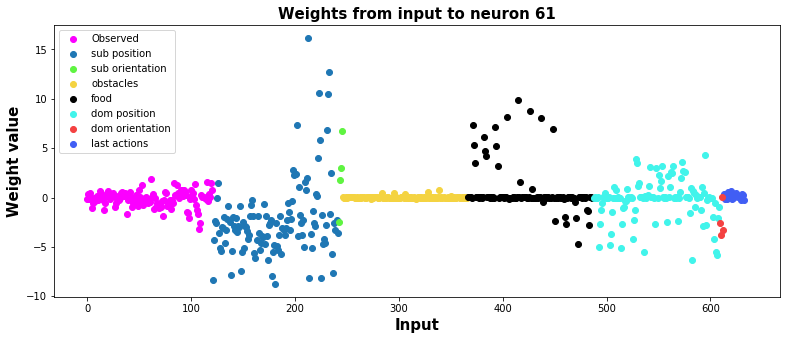

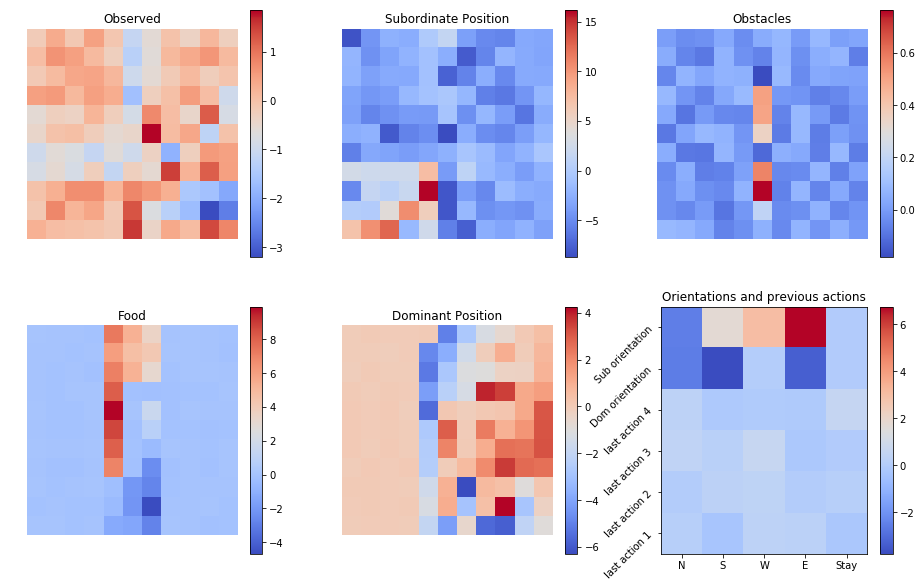

In [175]:
plotneuron(61)
plt.savefig('imgs/PN_61')
plotsquares(61)
plt.savefig('imgs/SN_61')

### Weights Input&rarr;neuron 76 neuron with most negative weight value in next layer

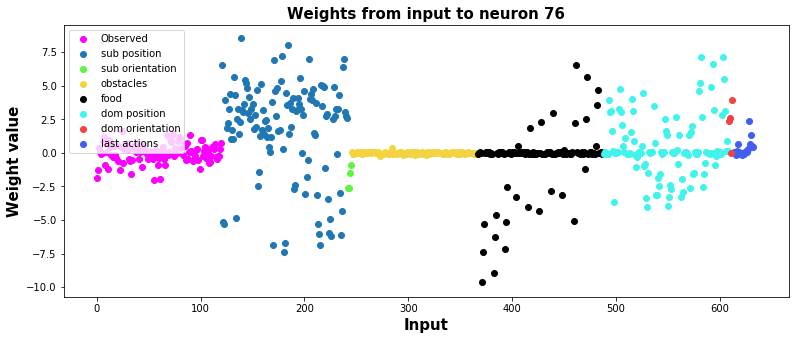

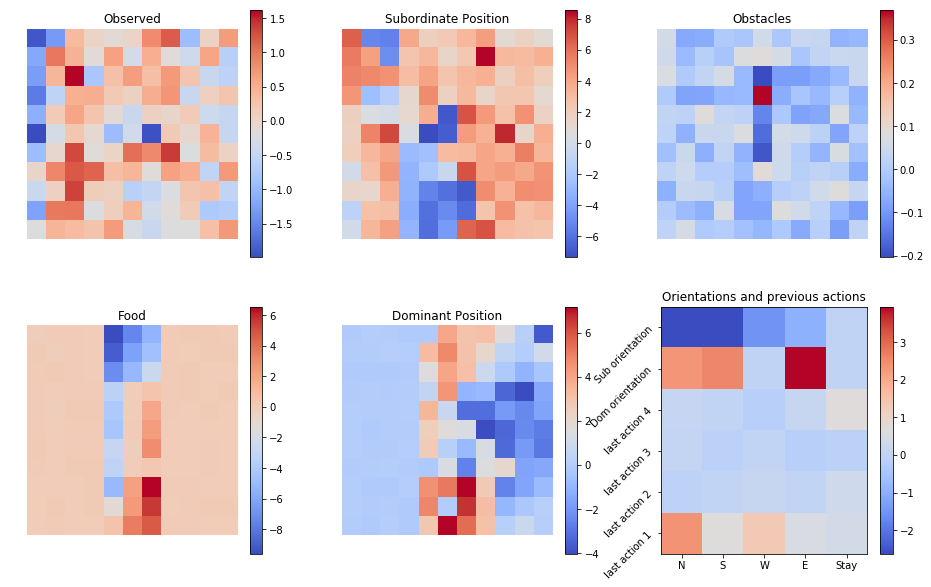

In [176]:
plotneuron(76)
plt.savefig('imgs/PN_76')
plotsquares(76)
plt.savefig('imgs/SN_76')

### Biases of Hidden nodes Input&rarr;Hidden Layer

 Max bias neuron: 29 
 Min bias neuron: 75


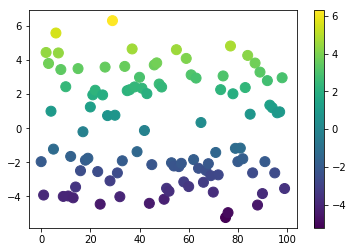

In [177]:
print(' Max bias neuron:',np.argmax(model.get_weights()[1]),'\n','Min bias neuron:',np.argmin(model.get_weights()[1]))
plt.scatter(np.array(range(100)),model.get_weights()[1],c=model.get_weights()[1],s=100)
plt.colorbar()
plt.show()

### All hidden layer neurons for all input. (just for general weights view) Input&rarr;hidden

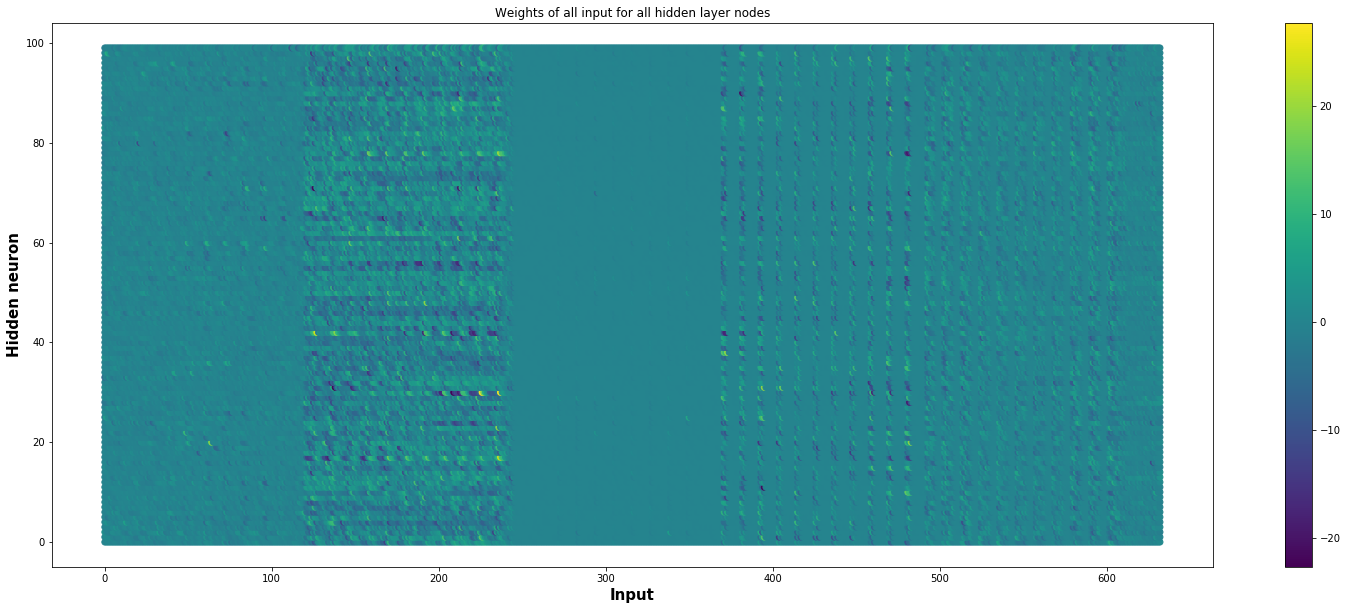

In [178]:
plt.figure(figsize=(26,10))
x = range(633)
y = range(100)
x,y = np.meshgrid(x,y)
#x,y=.meshgrid()
plt.scatter(x,y,c=model.get_weights()[0][x,y])
plt.xlabel('Input',fontsize=15,fontweight='bold')
plt.ylabel('Hidden neuron',fontsize=15,fontweight='bold')
plt.title('Weights of all input for all hidden layer nodes')
plt.colorbar()
plt.show()

### All hidden layer neurons for all input. (just for general weights view) Hidden&rarr;Advantages and State Value

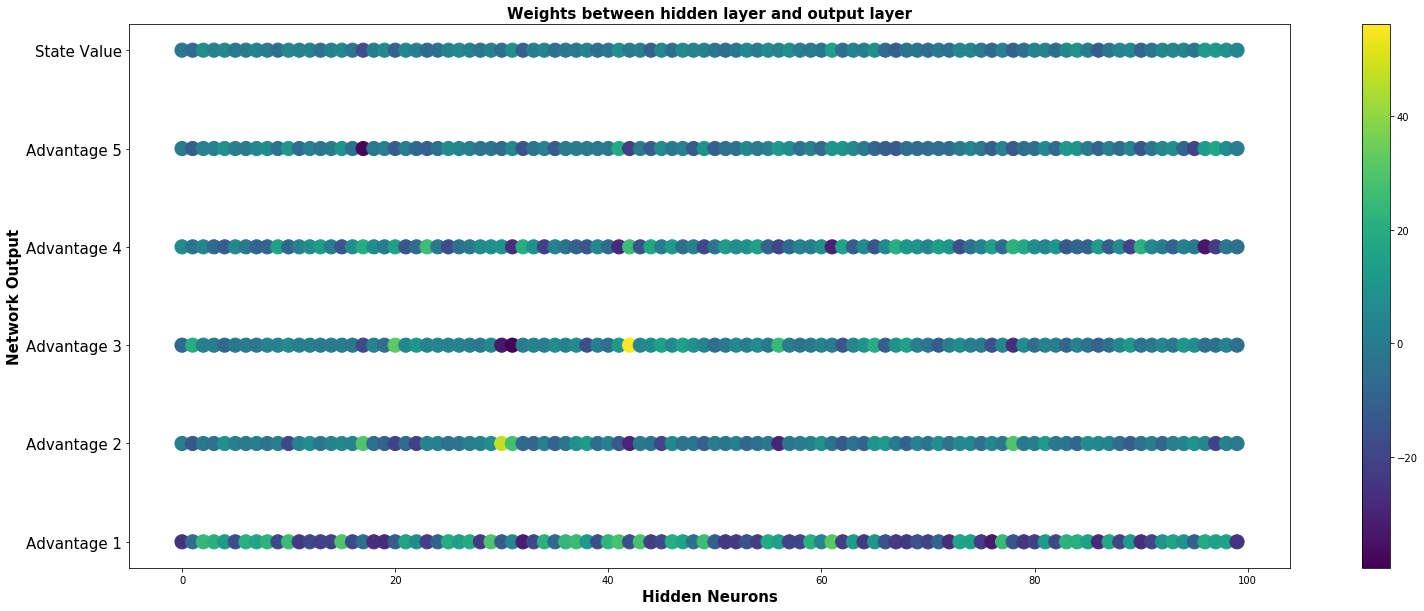

In [179]:
plt.figure(figsize=(26,10))
x = range(100)
y = range(6)
x,y = np.meshgrid(x,y)
#x,y=.meshgrid()
plt.scatter(x,y,c=model.get_weights()[2][x,y],s=200)
plt.xlabel('Hidden Neurons',fontsize=15,fontweight='bold')
plt.yticks(range(6),['Advantage 1','Advantage 2','Advantage 3','Advantage 4','Advantage 5','State Value'],fontsize=15)
plt.ylabel('Network Output',fontsize=15,fontweight='bold')
plt.title('Weights between hidden layer and output layer',fontsize=15,fontweight='bold')
plt.colorbar()
plt.show()

# T-SNE over weights between Input &rarr; hidden Layer

In [183]:
?plt.scatter

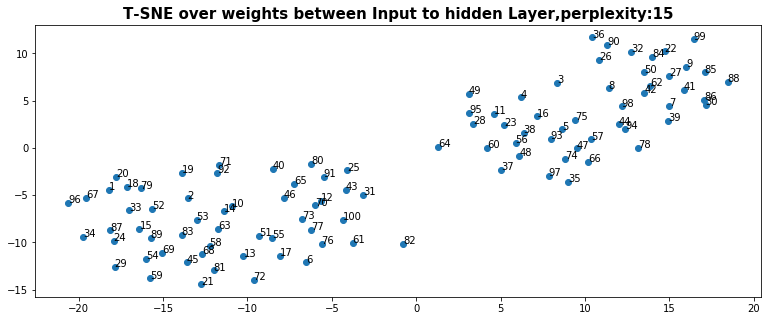

In [213]:
#for i in range(20):
TSNE_THIS(model.get_weights()[0],'T-SNE over weights between Input to hidden Layer',seed=1377,preplexity=15,
          metric='cosine',method='exact')
plt.savefig('imgs/TSNE_Weights.png')

# T-SNE Over the Input

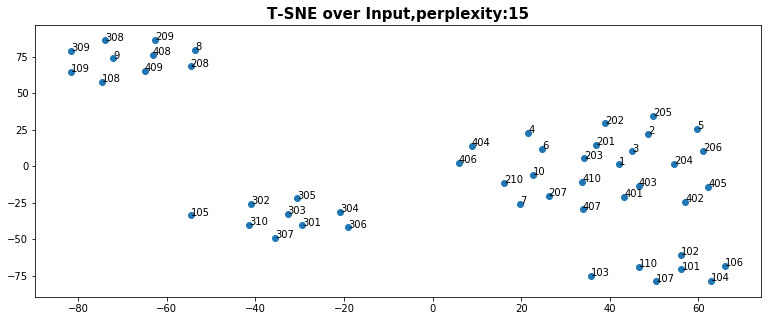

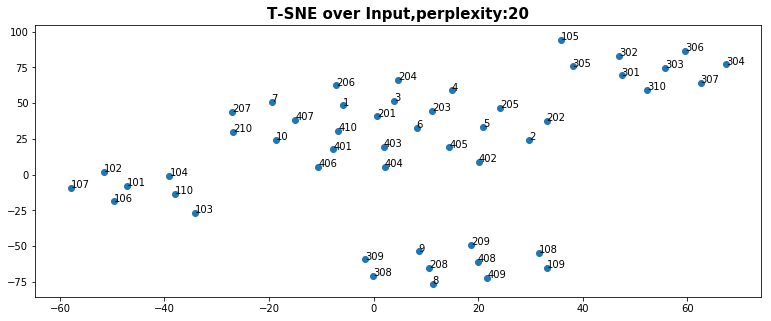

In [214]:
for i in [3,4]:
    TSNE_THIS(inputs[:,1:].T,'T-SNE over Input',names=inputs[:,0],seed=1377,preplexity=i*5)
#plt.savefig('imgs/TSNE_Weights.png')

# T-SNE over the advatages and state value (nothing interestsing)

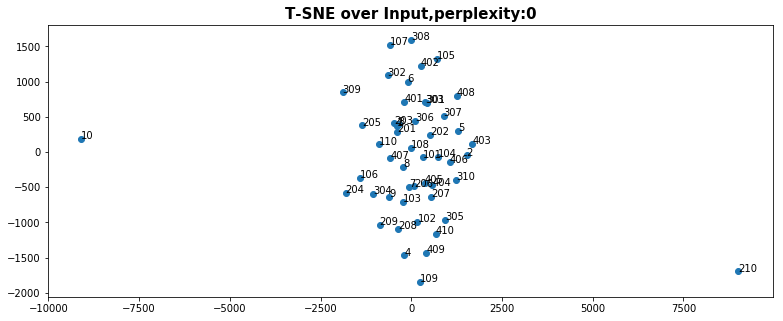

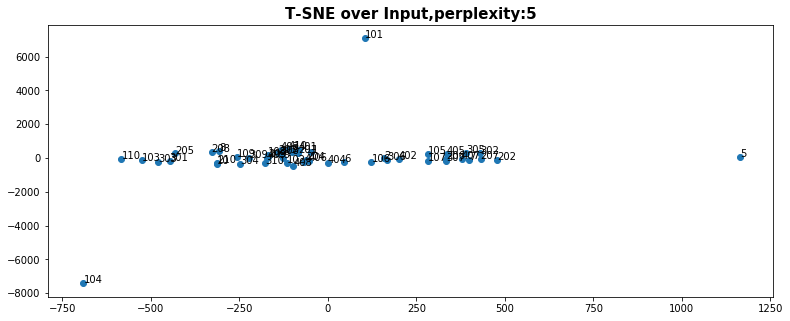

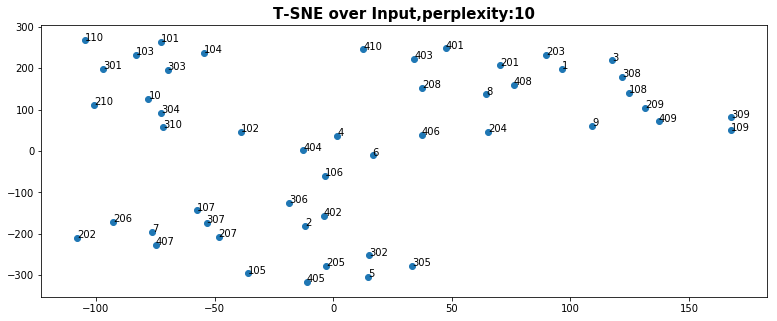

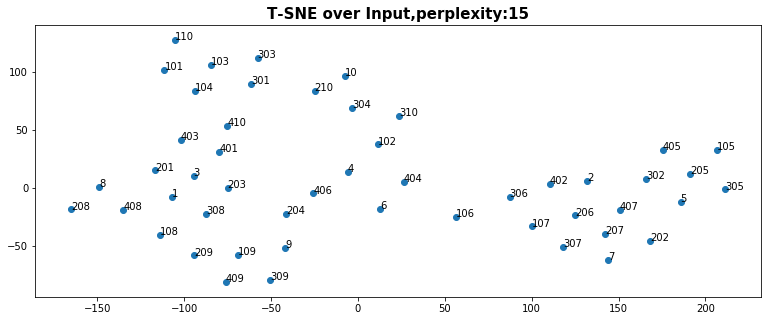

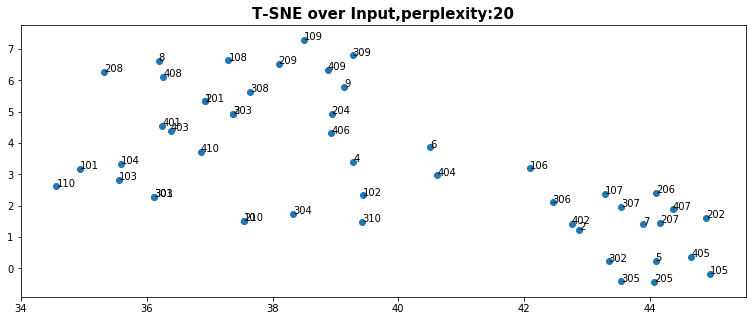

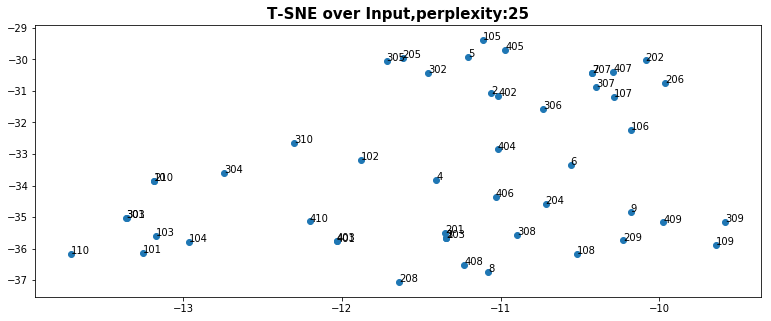

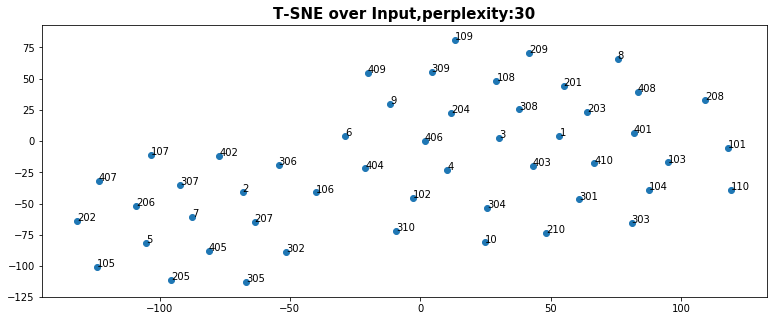

In [215]:
for i in range(7):
    TSNE_THIS(outputs[:,1:].T,'T-SNE over Input',names=outputs[:,0],seed=1377,preplexity=i*5)

# T-SNE over the advatages only (nothing interestsing)

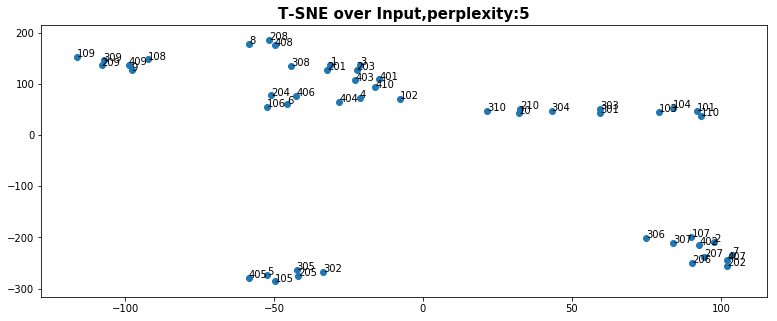

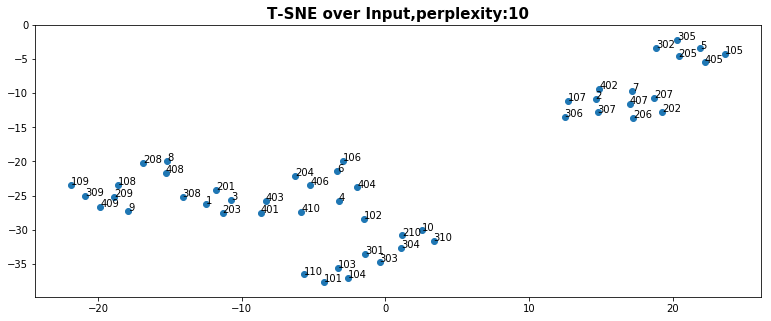

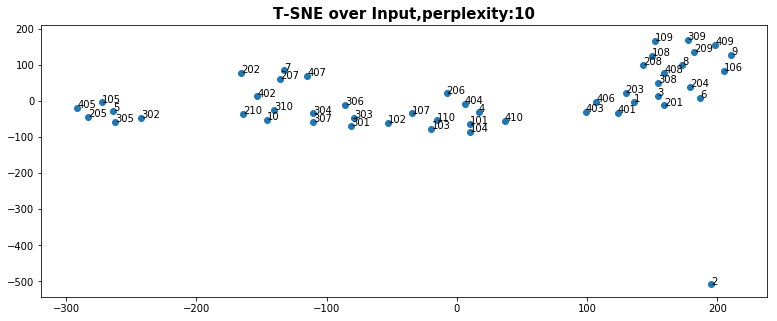

In [216]:
for i in [1,2]:
    TSNE_THIS(outputs[:,2:].T,'T-SNE over Input',names=outputs[:,0],seed=1377,preplexity=i*5)
for i in [2]:
    TSNE_THIS(outputs[:,2:].T,'T-SNE over Input',names=outputs[:,0],seed=1377,preplexity=i*5,metric='cosine',method='exact')

### T-SNE over 65 test cases (Activations)

### All test cases are in [ excel sheet ](https://docs.google.com/spreadsheets/d/1TZd7ThTngGcZwOxvm_6rmmVS7c8yLv5xslK36M4d6xY/edit#gid=0) 

### Test cases coded base on Expected  and Actual behavior
- triangle: go
- circle: avoid
- Blue: went.
- Red: avoided.

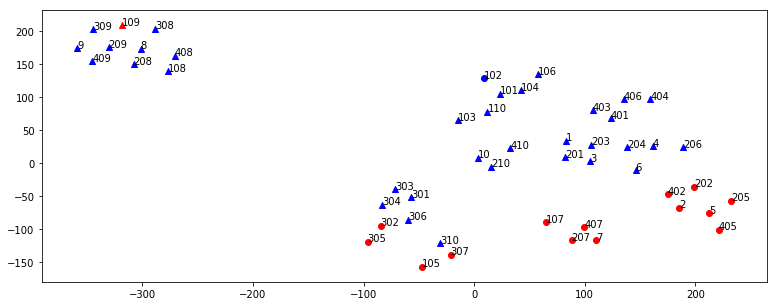

In [229]:
Expected_To_Go = PrepareTestCases([1,3,4,6,8,9,10])
Expected_Not_To_Go=PrepareTestCases([2,5,7])
Went = list(PrepareTestCases([1,3,4,6,8,9,10]))
Avoided=list(PrepareTestCases([2,5,7]))
Avoided.remove(102)
Avoided.append(109)
Went.append(102)
Went.remove(109)

#for i in range(1,4):
for i in [2]:
    TSNE_THIS(activations[:,1:].T,title='',#'Blue: went, R:  didn\'t go, G: deleted',
              names=activations[:,0],seed=4197,preplexity=i*5,
              redgroup=Avoided,bgroup=Went, trigroup=Expected_To_Go,circlgroup=Expected_Not_To_Go,
              metric='cosine',method='exact')
plt.savefig('imgs/EAB.png')

In [ ]:
for i in range(1,11):
    TSNE_THIS(activations[:,1:].T,title='T-SNE over Hidden activaton for All test cases (80)',names=activations[:,0],
              seed=4917,preplexity=i*5,redgroup=lstngo,ggroup=lstgo).show()

#for i in range(20):
#TSNE_THIS(model.get_weights()[0],'T-SNE over weights between Input to hidden Layer',seed=1377,preplexity=5).show()

### Plotting the weights for 100 neurons from input &rarr; hidden layer

In [ ]:
for i in range(100):
    plotneuron(i)
    plotsquares(i)